# End-to-End RAG Pipeline

Full RAG pipeline: PDF ingestion → Improved chunking → Embedding → ChromaDB → Retrieval → LLM answer

In [1]:
import sys
import os
from pathlib import Path

# Change to parent directory for config.yaml access
parent_dir = Path.cwd().parent
os.chdir(parent_dir)
sys.path.insert(0, str(parent_dir))

from pdfProcessing.docling_PDF_processor import DoclingPDFProcessor
from pdfProcessing.chunking import create_chunks_from_sections
from embeddingModels.ModernBertEmbedder import ModernBertEmbedder
from embeddingModels.QwenEmbedder import QwenEmbedder
from backend.services.embedder import EmbeddingService
from backend.services.vector_db import VectorDBService
from backend.services.rag_answer_service import ChromaRagRetriever
from llmAG.rag.pipeline import RagPipeline
from llmAG.llm import build_llm

import pandas as pd
import numpy as np

print(f"Working directory: {os.getcwd()}")

c:\Users\leonb\anaconda3\envs\GenAI2\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Working directory: c:\Users\leonb\Repos\GenAI


## 1. Initialize Services

In [2]:
# Configuration
EMBEDDER_TYPE = "bert"  # "bert" or "qwen"
CHROMA_PATH = "./backend/chroma_db"  # Use same DB as backend
MAX_CHUNK_SIZE = 2500
OVERLAP_SIZE = 200
TOP_K_RETRIEVAL = 5

# Database Management
CLEAR_DB_ON_RUN = False  # Set to True to clear DB and re-ingest all PDFs

# Set Ollama URL for local execution (not Docker)
os.environ["OLLAMA_BASE_URL"] = "http://localhost:11434"

# Initialize PDF processor
print("Initializing PDF processor...")
processor = DoclingPDFProcessor()

# Initialize embedding service
print("Initializing embedding service...")
embed_service = EmbeddingService()
# Load the model to have direct access to embedder for manual operations
embedder = embed_service.load_model(EMBEDDER_TYPE)

# Initialize ChromaDB service
print("Initializing ChromaDB...")
db_service = VectorDBService(
    db_path=CHROMA_PATH,
    collection_names={
        "bert": "scientific_papers_bert",
        "qwen": "scientific_papers_qwen"
    }
)

# Initialize LLM
print("Initializing LLM (Ollama mistral-nemo)...")
try:
    llm = build_llm(model="mistral-nemo", temperature=0.1)
    print("✓ LLM initialized")
except Exception as e:
    print(f"✗ LLM initialization failed: {e}")
    print("  Make sure Ollama app is running (check system tray)")
    llm = None


Initializing PDF processor...
Initializing Docling Converter...
CUDA not found. Using CPU for PDF Processing.
Initializing embedding service...
Loading Model Key: bert...
Loading Alibaba-NLP/gte-modernbert-base on cpu...
Initializing ChromaDB...
Initializing LLM (Ollama mistral-nemo)...
✓ LLM initialized


## 2. Ingest Pipeline (Optional - skipped if DB is populated)

In [3]:
# Database Management - Check and optionally clear database
print(f"{'='*80}")
print("DATABASE MANAGEMENT")
print(f"{'='*80}")

try:
    # Check current state
    collection = db_service.get_collection(EMBEDDER_TYPE)
    chunk_count = collection.count()
    
    print(f"Current database status (model: {EMBEDDER_TYPE})")
    print(f"  Chunks in database: {chunk_count}")
    print(f"  CLEAR_DB_ON_RUN flag: {CLEAR_DB_ON_RUN}")
    
    if CLEAR_DB_ON_RUN:
        if chunk_count > 0:
            print(f"  ⚠ Clearing existing {chunk_count} chunks...")
            # Clear the collection by deleting all documents
            all_ids = collection.get()['ids']
            if all_ids:
                collection.delete(ids=all_ids)
            print("  ✓ Database cleared")
        else:
            print("  ✓ Database already empty")
    else:
        if chunk_count > 0:
            print(f"  ℹ Keeping existing {chunk_count} chunks (CLEAR_DB_ON_RUN=False)")
            print(f"  ⏭ Skip cells 7-9 to use existing data")
        else:
            print(f"  ℹ Database is empty - proceed to cells 7-9 for ingestion")
    
    print(f"\n{'='*80}")
except Exception as e:
    print(f"Error managing database: {e}")

DATABASE MANAGEMENT
Current database status (model: bert)
  Chunks in database: 327
  CLEAR_DB_ON_RUN flag: False
  ℹ Keeping existing 327 chunks (CLEAR_DB_ON_RUN=False)
  ⏭ Skip cells 7-9 to use existing data



In [4]:
# Find PDFs in testPDFs folder
pdf_dir = Path.cwd() / "data" / "testPDFs"
pdf_files = list(pdf_dir.glob("*.pdf"))
print(f"Found {len(pdf_files)} PDFs in {pdf_dir}")
for i, pdf in enumerate(pdf_files[:5]):
    print(f"  {i}: {pdf.name}")

Found 13 PDFs in c:\Users\leonb\Repos\GenAI\data\testPDFs
  0: Kandel et al. - 2023 - Demonstration of an AI-driven workflow for autonomous high-resolution scanning microscopy.pdf
  1: Kuprikov et al. - 2022 - Deep reinforcement learning for self-tuning laser source of dissipative solitons.pdf
  2: MacLeod et al. - 2022 - A self-driving laboratory advances the Pareto front for material properties.pdf
  3: Mareev et al. - 2023 - Self-Adjusting Optical Systems Based on Reinforcement Learning.pdf
  4: Morgado et al. - 2024 - The rise of data‐driven microscopy powered by machine learning.pdf


In [5]:
def ingest_pdf(pdf_path: Path, model_key: str = "bert"):
    """
    Ingest single PDF: Process → Chunk → Embed → Store
    Replicates /ingest endpoint with improved chunking.
    """
    print(f"\nProcessing: {pdf_path.name}")
    
    # 1. Process PDF
    metadata, sections = processor.process_pdf(str(pdf_path))
    print(f"  Extracted {len(sections)} sections")
    
    # 2. Create improved chunks
    docs, metas, ids = create_chunks_from_sections(
        filename=pdf_path.name,
        metadata=metadata,
        sections=sections,
        max_chunk_size=MAX_CHUNK_SIZE,
        overlap_size=OVERLAP_SIZE
    )
    print(f"  Created {len(docs)} chunks (filtered & sized)")
    
    if not docs:
        print("  ✗ No chunks created (all filtered out)")
        return 0
    
    # 3. Embed chunks
    print(f"  Embedding with {model_key}...")
    embeddings = embedder.encode(docs)
    
    # 4. Store in ChromaDB
    db_service.upsert_chunks(
        model_key=model_key,
        ids=ids,
        documents=docs,
        embeddings=embeddings.tolist(),
        metadata=metas
    )
    
    print(f"  ✓ Ingested {len(docs)} chunks")
    return len(docs)

# Example: Ingest first PDF
# ingest_pdf(pdf_files[0], model_key=EMBEDDER_TYPE)

In [6]:
# Conditional ingestion based on CLEAR_DB_ON_RUN flag and database state
collection = db_service.get_collection(EMBEDDER_TYPE)
chunk_count = collection.count()

# Only ingest if database is empty OR CLEAR_DB_ON_RUN is True
if chunk_count == 0 or CLEAR_DB_ON_RUN:
    print(f"Ingesting {len(pdf_files)} PDFs into ChromaDB...")
    print(f"{'='*80}\n")
    
    total_chunks = 0
    for i, pdf in enumerate(pdf_files):
        print(f"[{i+1}/{len(pdf_files)}] Processing: {pdf.name}")
        chunks = ingest_pdf(pdf, model_key=EMBEDDER_TYPE)
        total_chunks += chunks
    
    print(f"\n{'='*80}")
    print(f"✓ INGESTION COMPLETE")
    print(f"  Total PDFs processed: {len(pdf_files)}")
    print(f"  Total chunks created: {total_chunks}")
    print(f"{'='*80}")
else:
    print(f"⏭ Skipping ingestion (CLEAR_DB_ON_RUN=False and database has {chunk_count} chunks)")
    print(f"   To re-ingest, set CLEAR_DB_ON_RUN=True in cell 4 and re-run cells 4-9")

⏭ Skipping ingestion (CLEAR_DB_ON_RUN=False and database has 327 chunks)
   To re-ingest, set CLEAR_DB_ON_RUN=True in cell 4 and re-run cells 4-9


## 3. Query & Retrieval

In [7]:
# User query
user_query = "What are the main challenges in autonomous microscopy?"

print(f"Query: {user_query}\n")

# Embed query
query_embedding = embedder.encode([user_query])[0]
print(f"Query embedding shape: {query_embedding.shape}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Query: What are the main challenges in autonomous microscopy?

Query embedding shape: (768,)


In [8]:
# Retrieve from ChromaDB
results = db_service.query(
    model_key=EMBEDDER_TYPE,
    query_embedding=query_embedding.tolist(),
    n_results=TOP_K_RETRIEVAL
)

print(f"\n{'='*80}")
print(f"RETRIEVED {len(results['ids'][0])} CHUNKS")
print(f"{'='*80}")


RETRIEVED 5 CHUNKS


### Inspection: Raw Retrieval Results

In [9]:
# Display retrieved chunks with metadata
for i in range(len(results['ids'][0])):
    chunk_id = results['ids'][0][i]
    distance = results['distances'][0][i]
    content = results['documents'][0][i]
    meta = results['metadatas'][0][i]
    
    print(f"\n{'='*80}")
    print(f"Rank {i+1} | Distance: {distance:.4f}")
    print(f"{'='*80}")
    print(f"ID:       {chunk_id}")
    print(f"Section:  {meta.get('section', 'N/A')}")
    print(f"Paper:    {meta.get('title', 'N/A')[:60]}...")
    print(f"Authors:  {meta.get('authors', 'N/A')[:60]}...")
    print(f"\nContent ({len(content)} chars):")
    print(f"{'-'*80}")
    print(content[:400] + "..." if len(content) > 400 else content)


Rank 1 | Distance: 0.2775
ID:       Morgado_et_al.___2024___The_rise_of_data‐driven_microscopy_powered_by_machine_learning.pdf#Conclusions_and_outlook_part1
Section:  Conclusions and outlook
Paper:    The Rise of Data-Driven Microscopy powered by Machine Learni...
Authors:  Leonor Morgado 1 , Estibaliz Gómez-de-Mariscal 1 , Hannah S....

Content (1753 chars):
--------------------------------------------------------------------------------
Additionally, package managers, such as BioImage Model Zoo (16), ZeroCostDL4Mic (17), and DL4MicEverywhere (18), that facilitate the sharing and installation of pre-trained models can help overcome barriers in deploying machine learning solutions. As data-driven microscopy moves beyond proof-of-concept studies, ensuring the robustness and reproducibility of autonomous microscopes becomes crucial. ...

Rank 2 | Distance: 0.2794
ID:       Morgado_et_al.___2024___The_rise_of_data‐driven_microscopy_powered_by_machine_learning.pdf#Applications_of_machine_

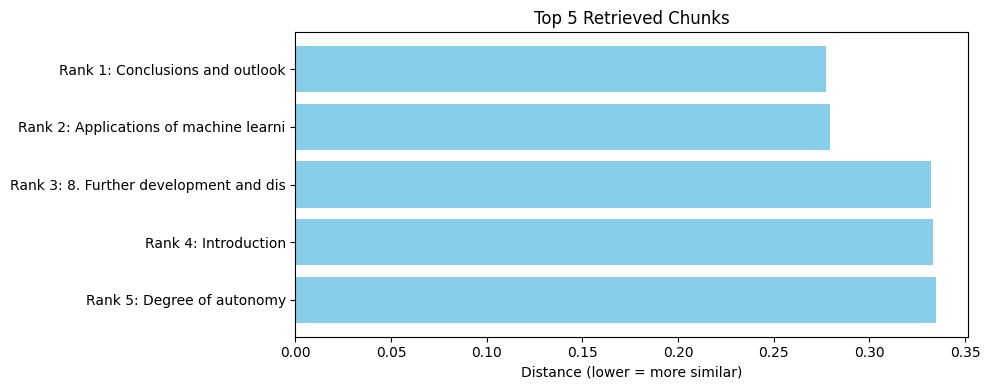

In [10]:
# Visualize retrieval scores
import matplotlib.pyplot as plt

distances = results['distances'][0]
sections = [results['metadatas'][0][i].get('section', 'Unknown')[:30] for i in range(len(distances))]

plt.figure(figsize=(10, 4))
plt.barh(range(len(distances)), distances, color='skyblue')
plt.yticks(range(len(distances)), [f"Rank {i+1}: {sections[i]}" for i in range(len(distances))])
plt.xlabel('Distance (lower = more similar)')
plt.title(f'Top {len(distances)} Retrieved Chunks')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 4. RAG Pipeline Execution

In [11]:
# Initialize RAG components
retriever = ChromaRagRetriever(
    embed_service=embed_service,
    db_service=db_service,
    model_name=EMBEDDER_TYPE
)

# Initialize RAG pipeline (builds LLM internally)
rag_pipeline = RagPipeline(
    retriever=retriever,
    model="mistral-nemo",
    temperature=0.1
)
print("✓ RAG pipeline initialized")

✓ RAG pipeline initialized


### Inspection: Context Sent to LLM

In [12]:
# Retrieve and format context (without LLM call)
retrieved_docs = retriever.get_relevant_documents(user_query, k=TOP_K_RETRIEVAL)

print(f"{'='*80}")
print(f"CONTEXT SENT TO LLM ({len(retrieved_docs)} chunks)")
print(f"{'='*80}\n")

for i, doc in enumerate(retrieved_docs):
    print(f"\n[CHUNK {i+1}]")
    print(f"Section: {doc.metadata.get('section', 'N/A')}")
    print(f"Paper: {doc.metadata.get('title', 'N/A')[:60]}")
    print(f"{'-'*80}")
    print(doc.page_content[:300] + "..." if len(doc.page_content) > 300 else doc.page_content)

# Show formatted context string
context_str = "\n\n".join([f"Source {i+1}:\n{doc.page_content}" for i, doc in enumerate(retrieved_docs)])
print(f"\n{'='*80}")
print(f"Full context length: {len(context_str)} characters, {len(context_str.split())} words")
print(f"{'='*80}")

CONTEXT SENT TO LLM (5 chunks)


[CHUNK 1]
Section: Conclusions and outlook
Paper: The Rise of Data-Driven Microscopy powered by Machine Learni
--------------------------------------------------------------------------------
Additionally, package managers, such as BioImage Model Zoo (16), ZeroCostDL4Mic (17), and DL4MicEverywhere (18), that facilitate the sharing and installation of pre-trained models can help overcome barriers in deploying machine learning solutions. As data-driven microscopy moves beyond proof-of-conc...

[CHUNK 2]
Section: Applications of machine learning powered reactive microscopy
Paper: The Rise of Data-Driven Microscopy powered by Machine Learni
--------------------------------------------------------------------------------
As machine learning methods and computational power continue advancing, we can expect even more breakthroughs in intelligent microscopy, bringing us closer to the goal of fully automated, optimised imaging platforms that accelerate biologica

### Inspection: Prompt Template

In [13]:
# Show the prompt templates available
if rag_pipeline is not None:
    # Get prompt templates from pipeline (stored in _prompts dict)
    print(f"{'='*80}")
    print("AVAILABLE PROMPT TEMPLATES")
    print(f"{'='*80}")
    
    for template_name, prompt_template in rag_pipeline._prompts.items():
        print(f"\n[{template_name.upper()}]")
        print(f"{'-'*80}")
        # Show the messages in the template
        for msg in prompt_template.messages:

            role = msg.__class__.__name__.replace('MessagePromptTemplate', '')            #print()
            print(f"{role}: {msg.prompt.template[:200]}..." if len(msg.prompt.template) > 200 else f"{role}: {msg.prompt.template}")

AVAILABLE PROMPT TEMPLATES

[ANSWER]
--------------------------------------------------------------------------------
System: You are a RAG assistant answering questions about scientific PDFs using only the provided context.
Use the context as the sole source of truth. Do not guess or use prior knowledge.
Answer with factual...
Human: Question: {question}

Context:
{context}

[MODE_A]
--------------------------------------------------------------------------------
System: You are a RAG assistant answering questions about a collection of scientific PDFs using only the provided context.
The question is a general collection query; synthesize across multiple papers when re...
Human: Question: {question}

Context:
{context}

[MODE_B]
--------------------------------------------------------------------------------
System: You are a RAG assistant answering questions about a collection of scientific PDFs using only the provided context.
The question is anchored to a specific paper in the colle

### Execute RAG Pipeline

In [14]:
if rag_pipeline is not None:
    print(f"\n{'='*80}")
    print(f"GENERATING ANSWER...")
    print(f"{'='*80}\n")
    
    try:
        # Run RAG pipeline
        response = rag_pipeline.run(user_query, k=TOP_K_RETRIEVAL, include_sources=True)
        
        print(f"{'='*80}")
        print("LLM ANSWER")
        print(f"{'='*80}\n")
        print(response.answer)
        
        print(f"\n{'='*80}")
        print(f"SOURCES ({len(response.sources)} documents)")
        print(f"{'='*80}")
        for i, source in enumerate(response.sources):
            print(f"\n[{i+1}] {source.metadata.get('title', 'Unknown')}")
            print(f"    Section: {source.metadata.get('section', 'N/A')}")
            print(f"    Content: {source.page_content[:150]}...")
            
    except Exception as e:
        print(f"✗ Error during RAG execution: {e}")
        print("  Check if Ollama is running: ollama run mistral-nemo")
else:
    print("✗ RAG pipeline not available - LLM not initialized")


GENERATING ANSWER...

LLM ANSWER

The main challenges in autonomous microscopy include:

- **Robustness and Reproducibility**: Ensuring the robustness and reproducibility of autonomous microscopes for extended durations is challenging [The Rise of Data-Driven Microscopy powered by Machine Learning | Conclusions and outlook].
- **Image Quality Control and Failure Detection**: Maintaining image quality control and detecting failures during unsupervised operation are significant challenges [The Rise of Data-Driven Microscopy powered by Machine Learning | Conclusions and outlook].
- **Validation of Machine Learning Predictions**: Extensive validation of machine learning predictions is required to build trust in intelligent systems and minimise user bias [The Rise of Data-Driven Microscopy powered by Machine Learning | Conclusions and outlook].
- **Constructing Robust Feedback Loops**: The difficulty in constructing robust feedback loops is a major obstacle to applying automated alignment 

## 5. Interactive Prototyping

In [15]:
def query_rag(question: str, top_k: int = 5, show_context: bool = False, show_sources: bool = True):
    """
    Interactive RAG query function.
    
    Args:
        question: User question
        top_k: Number of chunks to retrieve
        show_context: Print full context sent to LLM
        show_sources: Print source details
    """
    if rag_pipeline is None:
        print("✗ RAG pipeline not available")
        return None
    
    print(f"\n{'='*80}")
    print(f"Query: {question}")
    print(f"{'='*80}\n")
    
    # Retrieve context
    retrieved_docs = retriever.get_relevant_documents(question, k=top_k)
    print(f"Retrieved {len(retrieved_docs)} chunks\n")
    
    if show_context:
        print(f"{'='*80}")
        print("CONTEXT")
        print(f"{'='*80}")
        for i, doc in enumerate(retrieved_docs):
            print(f"\n[{i+1}] {doc.metadata.get('section', 'N/A')}")
            print(f"{doc.page_content[:200]}...\n")
    
    # Generate answer
    try:
        response = rag_pipeline.run(question, k=top_k, include_sources=True)
        
        print(f"{'='*80}")
        print("ANSWER")
        print(f"{'='*80}\n")
        print(response.answer)
        
        if show_sources:
            print(f"\n{'='*80}")
            print("SOURCES")
            print(f"{'='*80}")
            for i, source in enumerate(response.sources):
                print(f"\n[{i+1}] {source.metadata.get('title', 'Unknown')[:60]}")
                print(f"    Section: {source.metadata.get('section', 'N/A')}")
        
        return response
    except Exception as e:
        print(f"✗ Error: {e}")
        return None

In [16]:
def show_llm_prompt(question: str, top_k: int = 5, template_name: str = "answer"):
    """
    Display the exact prompt that will be sent to the LLM.
    
    Args:
        question: User question
        top_k: Number of chunks to retrieve
        template_name: Which prompt template to use (answer, mode_a, mode_b, mode_c, debug)
    """
    if rag_pipeline is None:
        print("✗ RAG pipeline not available")
        return
    
    # Retrieve documents
    retrieved_docs = retriever.get_relevant_documents(question, k=top_k)
    
    # Format context using the pipeline's internal method
    context = rag_pipeline._format_context(retrieved_docs)
    
    # Get the prompt template
    prompt_template = rag_pipeline._prompts.get(template_name, rag_pipeline._prompts["answer"])
    
    # Format the full prompt
    formatted_prompt = prompt_template.format_messages(question=question, context=context)
    
    # Display
    print(f"{'='*80}")
    print(f"EXACT PROMPT SENT TO LLM")
    print(f"{'='*80}")
    print(f"Template: {template_name}")
    print(f"Retrieved chunks: {len(retrieved_docs)}")
    print(f"Context length: {len(context)} chars\n")
    
    for i, msg in enumerate(formatted_prompt):
        role = msg.__class__.__name__.replace('Message', '').upper()
        print(f"\n{'='*80}")
        print(f"MESSAGE {i+1}: {role}")
        print(f"{'='*80}\n")
        print(msg.content)
    
    print(f"\n{'='*80}")
    print(f"Total prompt length: {sum(len(m.content) for m in formatted_prompt)} chars")
    print(f"{'='*80}")

In [17]:
# Show the exact prompt that will be sent to the LLM
show_llm_prompt(user_query, top_k=TOP_K_RETRIEVAL)

EXACT PROMPT SENT TO LLM
Template: answer
Retrieved chunks: 5
Context length: 6972 chars


MESSAGE 1: SYSTEM

You are a RAG assistant answering questions about scientific PDFs using only the provided context.
Use the context as the sole source of truth. Do not guess or use prior knowledge.
Answer with factual statements supported by the context.
Every factual claim must include an inline citation formatted as [Title | Section] placed immediately after the clause it supports.
Citations must use titles and section labels exactly as they appear in the context headers; do not invent, shorten, or paraphrase them.
If you cannot answer with exact [Title | Section] citations from the context, respond exactly with: "I do not know based on the provided context because the retrieved sections do not mention this. Would you like me to find related papers online?"
If the answer is not explicitly in the context, respond exactly with: "I do not know based on the provided context because the retrieved 

In [18]:
# Test different queries
query_rag("What are the main challenges in autonomous microscopy?")


Query: What are the main challenges in autonomous microscopy?

Retrieved 5 chunks

ANSWER

The main challenges in autonomous microscopy are:

- **Robustness and reproducibility**: Ensuring that autonomous microscopes maintain image quality control and detect failures during unsupervised operation over extended durations is challenging [The Rise of Data-Driven Microscopy powered by Machine Learning | Conclusions and outlook].
- **Validation and trust**: Building trust in intelligent systems requires extensive validation of machine learning predictions and adaptive decisions to minimize user bias [The Rise of Data-Driven Microscopy powered by Machine Learning | Conclusions and outlook].
- **Constructing robust feedbacks**: Existing beam diagnostics may have non-negligible backgrounds or malfunctioning pixels, interfering with simpler methods of estimating beam flux, position, and size from an image, which is crucial for Bayesian optimization [A general Bayesian algorithm for the autonom

RagResponse(answer='The main challenges in autonomous microscopy are:\n\n- **Robustness and reproducibility**: Ensuring that autonomous microscopes maintain image quality control and detect failures during unsupervised operation over extended durations is challenging [The Rise of Data-Driven Microscopy powered by Machine Learning | Conclusions and outlook].\n- **Validation and trust**: Building trust in intelligent systems requires extensive validation of machine learning predictions and adaptive decisions to minimize user bias [The Rise of Data-Driven Microscopy powered by Machine Learning | Conclusions and outlook].\n- **Constructing robust feedbacks**: Existing beam diagnostics may have non-negligible backgrounds or malfunctioning pixels, interfering with simpler methods of estimating beam flux, position, and size from an image, which is crucial for Bayesian optimization [A general Bayesian algorithm for the autonomous alignment of beamlines | 8. Further development and discussion].

### Query 2

This query is intended to test whether the system can correctly retrieve complex information from multiple sources at once. 

In [22]:
user_query2 = "Compare how the methods proposed by the different sources address the trade-off between image quality and sample damage. How do their approaches to 'scanning efficiency' differ from traditional raster-grid methods?"

show_llm_prompt(user_query2, top_k=TOP_K_RETRIEVAL)

EXACT PROMPT SENT TO LLM
Template: answer
Retrieved chunks: 5
Context length: 6230 chars


MESSAGE 1: SYSTEM

You are a RAG assistant answering questions about scientific PDFs using only the provided context.
Use the context as the sole source of truth. Do not guess or use prior knowledge.
Answer with factual statements supported by the context.
Every factual claim must include an inline citation formatted as [Title | Section] placed immediately after the clause it supports.
Citations must use titles and section labels exactly as they appear in the context headers; do not invent, shorten, or paraphrase them.
If you cannot answer with exact [Title | Section] citations from the context, respond exactly with: "I do not know based on the provided context because the retrieved sections do not mention this. Would you like me to find related papers online?"
If the answer is not explicitly in the context, respond exactly with: "I do not know based on the provided context because the retrieved 

In [23]:
query_rag(user_query2)


Query: Compare how the methods proposed by the different sources address the trade-off between image quality and sample damage. How do their approaches to 'scanning efficiency' differ from traditional raster-grid methods?

Retrieved 5 chunks

ANSWER

Based on the provided context, here's how the methods address the trade-off between image quality and sample damage:

1. **Numerical demonstration for scanning dark/uniFB01 eld microscopy**:
   - This method uses Fast Inverse Distance Weighting (IDW) algorithm for inpainting to reconstruct images from sparse data.
   - It aims to minimize the number of measurements while maintaining image quality, thus reducing sample damage [Article | Numerical demonstration...|].

2. **Deep reinforcement learning for data-driven adaptive scanning in ptychography**:
   - This approach uses a deep neural network to predict scan patterns based on prior knowledge about the sample, improving performance and potentially reducing measurement time.
   - It addr

RagResponse(answer="Based on the provided context, here's how the methods address the trade-off between image quality and sample damage:\n\n1. **Numerical demonstration for scanning dark/uniFB01 eld microscopy**:\n   - This method uses Fast Inverse Distance Weighting (IDW) algorithm for inpainting to reconstruct images from sparse data.\n   - It aims to minimize the number of measurements while maintaining image quality, thus reducing sample damage [Article | Numerical demonstration...|].\n\n2. **Deep reinforcement learning for data-driven adaptive scanning in ptychography**:\n   - This approach uses a deep neural network to predict scan patterns based on prior knowledge about the sample, improving performance and potentially reducing measurement time.\n   - It addresses the trade-off by adaptively selecting regions of interest for high-resolution scans [Deep reinforcement learning...|].\n\n3. **Self-driving scanning microscopy work /uniFB02 ow**:\n   - This method selects a batch of p

In [19]:
# query_rag("How does reinforcement learning improve optical systems?", top_k=3)

In [24]:
query_rag("What machine learning techniques are used for microscopy?", top_k=5)


Query: What machine learning techniques are used for microscopy?

Retrieved 5 chunks

ANSWER

Machine learning techniques used for microscopy include:
- Support Vector Machines (SVM) for image classification tasks such as identifying cell types [The Rise of Data-Driven Microscopy powered by Machine Learning | Machine learning for automated microscopy image analysis]

SOURCES

[1] The Rise of Data-Driven Microscopy powered by Machine Learni
    Section: Applications of machine learning powered reactive microscopy

[2] The Rise of Data-Driven Microscopy powered by Machine Learni
    Section: Machine learning for automated microscopy image analysis

[3] The Rise of Data-Driven Microscopy powered by Machine Learni
    Section: The Rise of Data-Driven Microscopy powered by Machine Learning

[4] The Rise of Data-Driven Microscopy powered by Machine Learni
    Section: Conclusions and outlook

[5] The Rise of Data-Driven Microscopy powered by Machine Learni
    Section: Machine learning for 

RagResponse(answer='Machine learning techniques used for microscopy include:\n- Support Vector Machines (SVM) for image classification tasks such as identifying cell types [The Rise of Data-Driven Microscopy powered by Machine Learning | Machine learning for automated microscopy image analysis]', sources=[Document(metadata={'section': 'Applications of machine learning powered reactive microscopy', 'filename': 'Morgado et al. - 2024 - The rise of data‐driven microscopy powered by machine learning.pdf', 'authors': 'Leonor Morgado 1 , Estibaliz Gómez-de-Mariscal 1 , Hannah S. Heil 1, , and Ricardo Henriques 1,2,, 1 Instituto Gulbenkian de Ciência, Oeiras, Portugal 2 MRC-Laboratory for Molecular Cell Biology. University College London, London, United Kingdom, Optical microscopy is an indispensable tool in life sciences research, but conventional techniques require compromises between imaging parameters like speed, resolution, field-of-view, and phototoxicity. To overcome these limitations,

In [27]:
query_rag("What machine learning techniques and reinforcement learning techniques are used for microscopy and adaptive laser beam culimation?", top_k=5)


Query: What machine learning techniques and reinforcement learning techniques are used for microscopy and adaptive laser beam culimation?

Retrieved 5 chunks

ANSWER

Based on the provided context:

- **Machine Learning Techniques**:
  - Convolutional Neural Networks (CNNs) are used for image segmentation in microscopy [The Rise of Data-Driven Microscopy powered by Machine Learning | Applications of machine learning powered reactive microscopy].
  - Deep Reinforcement Learning is employed for microscope autofocus tasks, specifically using a Liquid Lens Microscope System utilizing Deep Reinforcement Learning-based Autofocus (DRLAF) [ARTICLE | Abstract].

- **Reinforcement Learning Techniques**:
  - Deep Reinforcement Learning is used to learn the focusing strategy directly from captured images in microscopy [ARTICLE | Abstract].
  - The proposed study uses a custom-made liquid lens as an 'agent', raw images as the 'state', and voltage adjustments representing the 'actions' in its reinf

RagResponse(answer="Based on the provided context:\n\n- **Machine Learning Techniques**:\n  - Convolutional Neural Networks (CNNs) are used for image segmentation in microscopy [The Rise of Data-Driven Microscopy powered by Machine Learning | Applications of machine learning powered reactive microscopy].\n  - Deep Reinforcement Learning is employed for microscope autofocus tasks, specifically using a Liquid Lens Microscope System utilizing Deep Reinforcement Learning-based Autofocus (DRLAF) [ARTICLE | Abstract].\n\n- **Reinforcement Learning Techniques**:\n  - Deep Reinforcement Learning is used to learn the focusing strategy directly from captured images in microscopy [ARTICLE | Abstract].\n  - The proposed study uses a custom-made liquid lens as an 'agent', raw images as the 'state', and voltage adjustments representing the 'actions' in its reinforcement learning approach [ARTICLE | Abstract].", sources=[Document(metadata={'authors': 'Leonor Morgado 1 , Estibaliz Gómez-de-Mariscal 1 

## 6. Database Statistics

In [21]:
# Check what's in ChromaDB
try:
    collection = db_service.get_collection(EMBEDDER_TYPE)
    count = collection.count()
    
    print(f"\nChromaDB Statistics (model: {EMBEDDER_TYPE})")
    print(f"{'='*80}")
    print(f"Total chunks: {count}")
    
    # Sample some metadata
    if count > 0:
        sample = collection.get(limit=10)
        if sample['metadatas']:
            unique_papers = set(m.get('title', 'Unknown') for m in sample['metadatas'])
            print(f"Sample papers ({len(unique_papers)} unique):")
            for paper in list(unique_papers)[:5]:
                print(f"  - {paper[:70]}")
except Exception as e:
    print(f"Error accessing ChromaDB: {e}")


ChromaDB Statistics (model: bert)
Total chunks: 327
Sample papers (1 unique):
  - Article
